# Case study of uniaxial tensile tests

This is an example of how to use ParaMaterial to process a dataset of uniaxial tensile test measurements.



## Data processing
- **Trim data.**
- **Screen trimming.**
- **Make representative curves.**

Import libraries and objects.

In [1]:
import numpy as np
import pandas as pd

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

A quick reminder of the prepared data.

In [2]:
prepared_set = DataSet('data/01 prepared data', 'info/01 prepared info.xlsx').sort_by(['temperature', 'lot'])

styler = pam.plotting.Styler(
    color_by='temperature', cmap='plasma', cbar=True, cbar_label='Temperature (°C)',
    linestyle_by='test type', linestyle_by_label='Type',
    plot_kwargs={'grid': True}
).style_to(prepared_set)


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


# ds_plot(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.8);

We will only be processing and analysing the uniaxial tension data. We can filter the dataset as follows.

In [12]:
prepared_set = prepared_set[{'test type': ['UT']}]  # filter dataset
print(prepared_set.info_table.value_counts(['test type']))
# ds_plot(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.8);

test type
UT           100
dtype: int64


We want to trim the trailing data.

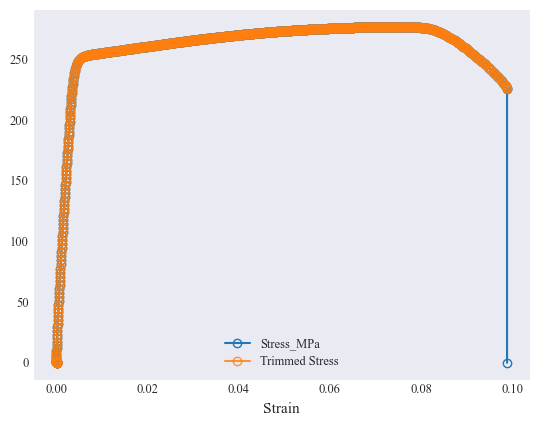

In [4]:
df = prepared_set[0].data  # get example dataitem data
ax = df.plot(x='Strain', y='Stress_MPa', marker='o', mfc='none')
# remove the last data point
df[:-1].plot(x='Strain', y='Stress_MPa', label='Trimmed Stress', marker='o', mfc='none', ax=ax, alpha=0.8);

Check if this approach works for entire dataset.

In [13]:
def trim(di: DataItem) -> DataItem:
    di.data = di.data[:-1]
    return di


trimmed_set = prepared_set.apply(trim)
assert(all(type(di.info) == pd.Series for di in trimmed_set))
print(trimmed_set.info_table.value_counts(['test type']))


test type
UT           100
dtype: int64


In [6]:
styler.linestyle_by = None
styler.linestyle_by_label = None
styler.color_by_label = '(°C)'
styler.cbar = False


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
        ds=ds, shape=(3, 3), sharex='all',
        styler=styler, hspace=0.2, plot_legend=False,
        rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
        cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
        plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI'],
        **kwargs
    )


# axs = ds_subplots(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.2)
# axs = ds_subplots(trimmed_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.2)
# ds_subplots(trimmed_set, x='Strain', y='Stress_MPa', axs=axs);

The approach worked for most, but not all. We use the screening pdf to trim the remainder.

In [7]:
def screening_plot(di: DataItem) -> None:
    test_id = di.test_id
    # plot the untrimmed dataitem
    ax = ds_plot(prepared_set[{'test id': [test_id]}], x='Strain', y='Stress_MPa', alpha=0.2)
    # plot the trimmed dataitem
    ds_plot(trimmed_set[{'test id': [test_id]}], x='Strain', y='Stress_MPa', ax=ax)

assert(all(type(di.info) == pd.Series for di in trimmed_set))

# pam.processing.make_screening_pdf(trimmed_set, screening_plot, '02 trimming screening.pdf')

In [14]:
assert(all(type(di.info) == pd.Series for di in trimmed_set))
print(trimmed_set.info_table.value_counts(['test type']))

trimmed_set = pam.processing.read_screening_pdf_to(trimmed_set, '02 trimming screening marked.pdf')
trimmed_set.info_table['comment'].unique()

test type
UT           100
dtype: int64


AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [ ]:
trimmed_set

In [ ]:
def screening_comment_trim(di: DataItem) -> DataItem:
    if str(di.info['comment']).startswith('trim at'):
        trim_strain = di.info['comment'].split(' ')[2]
        di.data = di.data[di.data['Strain'] <= float(trim_strain)]
        return di
    else:
        return di


trimmed_set = trimmed_set.apply_function(screening_comment_trim)
axs = ds_subplots(prepared_set, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)', alpha=0.2)
ds_subplots(trimmed_set, x='Strain', y='Stress_MPa', axs=axs);

"Starting from a preload (which was chosen to be 30 lbf to minimize errors in the strain measurements caused by factors such as initial grip alignment), the upper proportional limit (UPL) is determined by linear regression as the point that minimizes the residuals of the slope fit between that point and the preload.

Then, starting from this UPL, the procedure was repeated in the opposite direction to obtain the lower proportional limit (LPL).

This procedure is automated and the proportional limits are consistently identified for all stress-strain curves using this criteria.

The elastic modulus is calculated as the slope of the best fit straight line between the upper and lower proportional limits.

Foot correction is applied to the stress-strain curve such that the linear elastic portion of the curve begins at the origin.

The 0.2% proof stress is then determined using this slope with an offset of 0.2% strain and is recorded as the yield stress and the corresponding strain is noted as the strain at yield.

From the upper proportional limit to the yield point, the Ramberg-Osgood model is fit to the data, and the fit parameter n is estimated by regression."

30 lbf of force is equivalent to 133.5 Newtons. Since we don't have the force data, we calculate